# Flight Delay Prediction - XGBoost Model Training and Visualization

This notebook trains XGBoost models for flight delay prediction (both regression and classification) and generates comprehensive visualizations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Import our custom XGBoost class
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from src.models.XGBoost import FlightDelayPredictor

# Create directories for results
import os
os.makedirs('../results/figures', exist_ok=True)
os.makedirs('../results/models', exist_ok=True)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Environment setup complete!")

✅ Environment setup complete!


In [9]:
# Configuration Section
CONFIG = {
    'classification_data_path': '../data/processed/flight_delays_engineered.csv',
    'regression_data_path': '../data/processed/flight_delays_engineered_regression.csv',
    'test_size': 0.2,
    'random_state': 42,
    'classification_threshold': 15,  # Minutes threshold for binary classification
    'save_figures': True
}

# Model configurations
REGRESSION_CONFIG = {
    'n_estimators': 1576,
    'max_depth': 9,
    'learning_rate': 0.2342,
    'subsample': 0.8347,
    'colsample_bytree': 0.9378,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 50,
    'eval_metric': 'mae'
}

CLASSIFICATION_CONFIG = {
    'n_estimators': 1516,
    'max_depth': 6,
    'learning_rate': 0.2880,
    'subsample': 0.9378,
    'colsample_bytree': 0.7581,
    'random_state': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 50,
    'eval_metric': 'logloss'
}

BALANCING_CONFIG = {
    'method': 'class_weight'  # Options: 'none', 'class_weight', 'smote', 'undersample'
}

print("✅ Configuration loaded!")

✅ Configuration loaded!


In [3]:
# Data Exploration and Visualization

def load_and_explore_data(data_path):
    """Load and explore the flight delay dataset."""
    print("📊 Loading and exploring data...")
    
    try:
        df = pd.read_csv(data_path)
        print(f"✅ Data loaded successfully: {df.shape[0]:,} rows, {df.shape[1]:,} columns")
        
        # Basic info
        print("\n📈 Dataset Info:")
        print(f"Columns: {list(df.columns)}")
        print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        return df
    except FileNotFoundError:
        print(f"❌ File not found: {data_path}")
        print("Please update the CONFIG['data_path'] with your actual data path")
        return None

# Load data
df = load_and_explore_data(CONFIG['classification_data_path'])

if df is not None:
    # Display basic statistics
    print("\n📊 Basic Statistics:")
    print(df.describe())
    
    # Check for missing values
    print("\n🔍 Missing Values:")
    missing_data = df.isnull().sum()
    print(missing_data[missing_data > 0])

📊 Loading and exploring data...
✅ Data loaded successfully: 1,527,160 rows, 19 columns

📈 Dataset Info:
Columns: ['Date (YYYY-MM-DD)', 'Scheduled Elapsed Time (Minutes)', 'IsWeekend', 'Is_Holiday_Period', 'Carrier_9E', 'Carrier_AA', 'Carrier_AS', 'Carrier_DL', 'Carrier_EV', 'Carrier_MQ', 'Carrier_NK', 'Carrier_OO', 'Carrier_UA', 'Carrier_WN', 'Carrier_YX', 'Origin_Airport_Encoded', 'Season_Encoded', 'Arrival Delay (Minutes)', 'Is_Delayed']
Memory usage: 307.30 MB

📊 Basic Statistics:
       Scheduled Elapsed Time (Minutes)     IsWeekend  Is_Holiday_Period  \
count                      1.527160e+06  1.527160e+06       1.527160e+06   
mean                       1.240804e+02  2.682260e-01       1.130615e-01   
std                        5.405475e+01  4.430360e-01       3.166681e-01   
min                        4.000000e+01  0.000000e+00       0.000000e+00   
25%                        8.900000e+01  0.000000e+00       0.000000e+00   
50%                        1.140000e+02  0.000000e+00  


🎨 Creating data distribution plots...


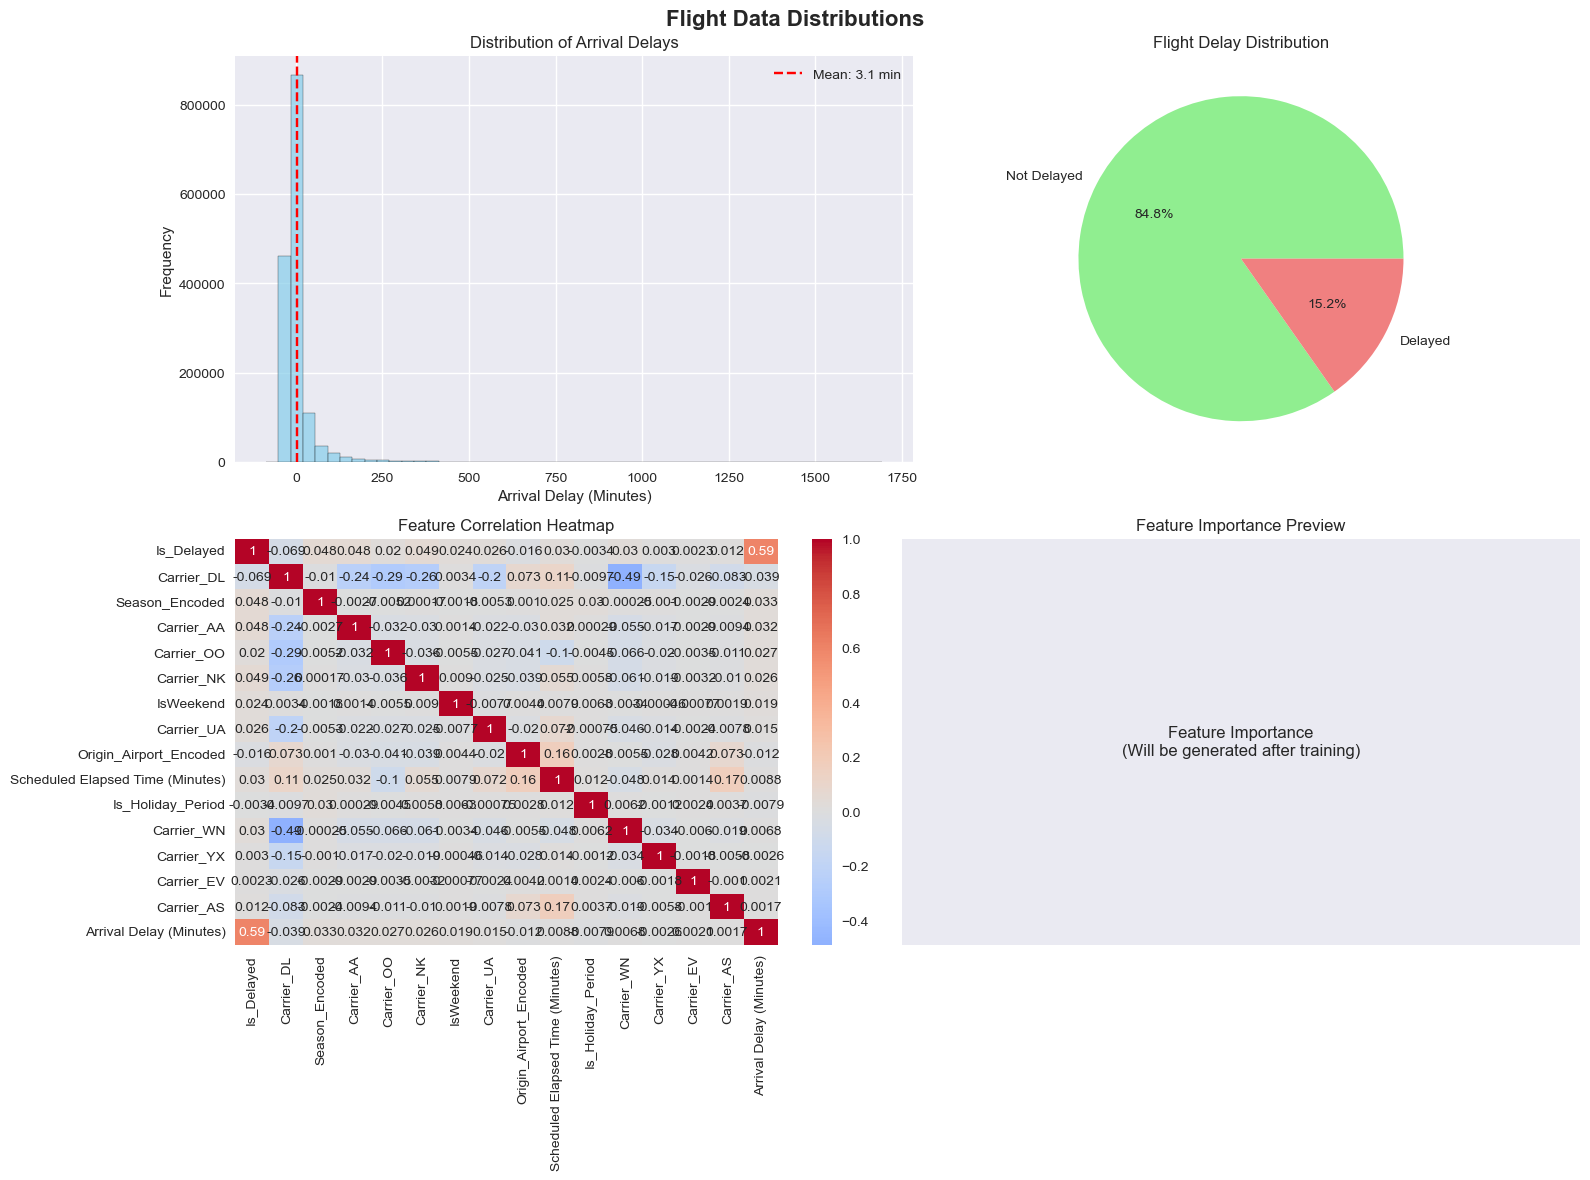

In [4]:
def plot_data_distributions(df):
    """Create comprehensive data distribution plots."""
    print("\n🎨 Creating data distribution plots...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Flight Data Distributions', fontsize=16, fontweight='bold')
    
    # 1. Arrival Delay Distribution
    if 'Arrival Delay (Minutes)' in df.columns:
        axes[0, 0].hist(df['Arrival Delay (Minutes)'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].set_xlabel('Arrival Delay (Minutes)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of Arrival Delays')
        axes[0, 0].axvline(df['Arrival Delay (Minutes)'].mean(), color='red', linestyle='--', 
                          label=f'Mean: {df["Arrival Delay (Minutes)"].mean():.1f} min')
        axes[0, 0].legend()
    
    # 2. Delay Categories (if exists or create)
    if 'Is_Delayed' in df.columns:
        delay_counts = df['Is_Delayed'].value_counts()
        axes[0, 1].pie(delay_counts.values, labels=['Not Delayed', 'Delayed'], autopct='%1.1f%%', 
                      colors=['lightgreen', 'lightcoral'])
        axes[0, 1].set_title('Flight Delay Distribution')
    elif 'Arrival Delay (Minutes)' in df.columns:
        # Create binary classification
        is_delayed = (df['Arrival Delay (Minutes)'] > CONFIG['classification_threshold']).astype(int)
        delay_counts = is_delayed.value_counts()
        axes[0, 1].pie(delay_counts.values, labels=['Not Delayed', 'Delayed'], autopct='%1.1f%%',
                      colors=['lightgreen', 'lightcoral'])
        axes[0, 1].set_title(f'Flight Delay Distribution (> {CONFIG["classification_threshold"]} min)')
    
    # 3. Correlation heatmap (top 15 features with target)
    if 'Arrival Delay (Minutes)' in df.columns:
        # Select numeric columns and compute correlation
        numeric_df = df.select_dtypes(include=[np.number])
        if len(numeric_df.columns) > 15:
            # Get top 15 features correlated with target
            corr_with_target = numeric_df.corr()['Arrival Delay (Minutes)'].abs().sort_values(ascending=False)
            top_features = corr_with_target[1:16].index.tolist()  # Exclude target itself
            top_features.append('Arrival Delay (Minutes)')
            numeric_df = numeric_df[top_features]
        
        corr_matrix = numeric_df.corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 0])
        axes[1, 0].set_title('Feature Correlation Heatmap')
    
    # 4. Feature importance preview (placeholder)
    axes[1, 1].text(0.5, 0.5, 'Feature Importance\n(Will be generated after training)', 
                   ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
    axes[1, 1].set_title('Feature Importance Preview')
    axes[1, 1].set_xticks([])
    axes[1, 1].set_yticks([])
    
    plt.tight_layout()
    
    # if CONFIG['save_figures']:
    #     plt.savefig('../results/figures/data_distributions.png', dpi=300, bbox_inches='tight')
    #     print("✅ Saved data distributions plot")
    
    plt.show()

if df is not None:
    plot_data_distributions(df)

In [ ]:
# Hyperparameter Tuning for XGBoost Models

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, f1_score
from xgboost import XGBRegressor, XGBClassifier
import scipy.stats as stats
import json

def tune_hyperparameters():
    """Perform hyperparameter tuning for both regression and classification models."""
    print("\n" + "="*70)
    print("🔧 HYPERPARAMETER TUNING")
    print("="*70)
    
    # Define parameter search spaces (aligned with FlightDelayPredictor defaults)
    REGRESSION_PARAM_GRID = {
        'n_estimators': stats.randint(500, 2000),
        'max_depth': stats.randint(3, 10),
        'learning_rate': stats.uniform(0.01, 0.3),
        'subsample': stats.uniform(0.6, 0.4),  # 0.6 to 1.0
        'colsample_bytree': stats.uniform(0.6, 0.4)  # 0.6 to 1.0
    }

    CLASSIFICATION_PARAM_GRID = {
        'n_estimators': stats.randint(500, 2000),
        'max_depth': stats.randint(3, 8),
        'learning_rate': stats.uniform(0.01, 0.3),
        'subsample': stats.uniform(0.6, 0.4),
        'colsample_bytree': stats.uniform(0.6, 0.4),
        'scale_pos_weight': stats.uniform(1, 5)  # For imbalanced classes
    }
    
    # Load sample data for tuning
    print("📊 Loading sample data for tuning...")
    
    # Regression data
    reg_model_temp = FlightDelayPredictor(task_type='regression')
    X_reg, y_reg = reg_model_temp.load_data(CONFIG['regression_data_path'])
    X_train_reg, X_val_reg, y_train_reg, y_val_reg = reg_model_temp.train_test_split(
        X_reg, y_reg, test_size=0.2, random_state=42
    )
    
    # Classification data
    clf_model_temp = FlightDelayPredictor(task_type='classification', balancing=BALANCING_CONFIG)
    X_clf, y_clf = clf_model_temp.load_data(CONFIG['classification_data_path'])
    X_train_clf, X_val_clf, y_train_clf, y_val_clf = clf_model_temp.train_test_split(
        X_clf, y_clf, test_size=0.2, random_state=42
    )
    
    print(f"Using {len(X_train_reg):,} samples for regression tuning")
    print(f"Using {len(X_train_clf):,} samples for classification tuning")
    
    # Regression Tuning
    print("\n🔧 Tuning Regression Model...")
    reg_base = XGBRegressor(
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=25,
        eval_metric='mae'
    )
    
    reg_search = RandomizedSearchCV(
        reg_base,
        REGRESSION_PARAM_GRID,
        n_iter=25,  # Reduced to 25 combinations
        cv=3,  # 3-fold cross-validation
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Pass validation data for early stopping
    reg_search.fit(
        X_train_reg, y_train_reg,
        **{'eval_set': [(X_val_reg, y_val_reg)], 'verbose': False}
    )
    best_reg_params = reg_search.best_params_
    
    print(f"✅ Best Regression Params: {best_reg_params}")
    print(f"   Best CV Score (MAE): {-reg_search.best_score_:.2f}")
    
    # Classification Tuning
    print("\n🎯 Tuning Classification Model...")
    clf_base = XGBClassifier(
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=25,
        eval_metric='logloss'
    )
    
    clf_search = RandomizedSearchCV(
        clf_base,
        CLASSIFICATION_PARAM_GRID,
        n_iter=25,  # Reduced to 25 combinations
        cv=3,
        scoring='f1',  # Optimize for F1 score
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Pass validation data for early stopping
    clf_search.fit(
        X_train_clf, y_train_clf,
        **{'eval_set': [(X_val_clf, y_val_clf)], 'verbose': False}
    )
    best_clf_params = clf_search.best_params_
    
    print(f"✅ Best Classification Params: {best_clf_params}")
    print(f"   Best CV Score (F1): {clf_search.best_score_:.4f}")
    
    # Save best parameters
    best_params = {
        'regression': best_reg_params,
        'classification': best_clf_params,
        'tuning_info': {
            'n_iterations': 25,  # Updated to reflect the reduced number of iterations
            'cv_folds': 3,
            'timestamp': pd.Timestamp.now().isoformat()
        }
    }
    
    with open('../results/models/best_hyperparameters.json', 'w') as f:
        json.dump(best_params, f, indent=2)
    
    print("💾 Saved best parameters to: ../results/models/best_hyperparameters.json")
    print("\n📋 RECOMMENDED CONFIGURATIONS:")
    print("=" * 50)
    
    print("\n🔧 REGRESSION_CONFIG = {")
    for key, value in best_reg_params.items():
        if isinstance(value, float):
            print(f"    '{key}': {value:.4f},")
        else:
            print(f"    '{key}': {value},")
    print("    'random_state': 42,")
    print("    'n_jobs': -1,")
    print("    'early_stopping_rounds': 50,")
    print("    'eval_metric': 'mae'")
    print("}")
    
    print("\n🎯 CLASSIFICATION_CONFIG = {")
    for key, value in best_clf_params.items():
        if isinstance(value, float):
            print(f"    '{key}': {value:.4f},")
        else:
            print(f"    '{key}': {value},")
    print("    'random_state': 42,")
    print("    'n_jobs': -1,")
    print("    'early_stopping_rounds': 50,")
    print("    'eval_metric': 'logloss'")
    print("}")
    
    return best_reg_params, best_clf_params

# Run hyperparameter tuning
print("⚠️  WARNING: This tuning process may take 10-30 minutes depending on your hardware")
print("   Consider reducing n_iter if it's too slow")

# Uncomment the line below to run tuning
best_reg_params, best_clf_params = tune_hyperparameters()

# For now, just show the function is ready
print("✅ Hyperparameter tuning function is ready!")

⚠️  WARNING: This tuning process may take 10-30 minutes depending on your hardware
   Consider reducing n_iter if it's too slow

🔧 HYPERPARAMETER TUNING
📊 Loading sample data for tuning...
📊 Loading and exploring data...
✓ Removed Date column (redundant - already captured in seasonal features)
✓ Feature dtypes after preprocessing:
  - Scheduled Elapsed Time (Minutes): int64
  - IsWeekend: int64
  - Is_Holiday_Period: int64
  - Carrier_9E: int64
  - Carrier_AA: int64
  - Carrier_AS: int64
  - Carrier_DL: int64
  - Carrier_EV: int64
  - Carrier_MQ: int64
  - Carrier_NK: int64
  - Carrier_OO: int64
  - Carrier_UA: int64
  - Carrier_WN: int64
  - Carrier_YX: int64
  - Origin_Airport_Encoded: int64
  - Season_Encoded: int64
✓ Loaded regression dataset: 1,519,602 rows, 16 features
✓ Target: Arrival Delay (Minutes)
✓ Delay range: [-60.0, 300.0] minutes
✓ Mean delay: 0.58 minutes
✓ Train-test split: 1,215,681 train, 303,921 test samples
📊 Loading and exploring data...
✓ Removed Date column (re

In [10]:
# Model Training - Regression

def train_regression_model():
    """Train regression model to predict delay minutes."""
    print("\n" + "="*60)
    print("🚀 TRAINING REGRESSION MODEL")
    print("="*60)
    
    # Initialize model
    reg_model = FlightDelayPredictor(
        task_type='regression',
        config=REGRESSION_CONFIG
    )
    
    # Load data
    X, y = reg_model.load_data(CONFIG['regression_data_path'])
    
    # Split data
    X_train, X_test, y_train, y_test = reg_model.train_test_split(
        X, y, 
        test_size=CONFIG['test_size'], 
        random_state=CONFIG['random_state']
    )
    
    # Train model
    reg_model.train(X_train, y_train, X_test, y_test)
    
    # Make predictions
    y_pred = reg_model.predict(X_test)
    
    # Evaluate model
    metrics_reg = reg_model.evaluate(y_test, y_pred, "Regression Test")
    
    # Get feature importance
    feature_importance_reg = reg_model.get_feature_importance(top_n=15)
    
    return reg_model, X_test, y_test, y_pred, metrics_reg, feature_importance_reg

# Train regression model
regression_results = train_regression_model()
reg_model, X_test_reg, y_test_reg, y_pred_reg, metrics_reg, feature_importance_reg = regression_results


🚀 TRAINING REGRESSION MODEL
📊 Loading and exploring data...
✓ Removed Date column (redundant - already captured in seasonal features)
✓ Feature dtypes after preprocessing:
  - Scheduled Elapsed Time (Minutes): int64
  - IsWeekend: int64
  - Is_Holiday_Period: int64
  - Carrier_9E: int64
  - Carrier_AA: int64
  - Carrier_AS: int64
  - Carrier_DL: int64
  - Carrier_EV: int64
  - Carrier_MQ: int64
  - Carrier_NK: int64
  - Carrier_OO: int64
  - Carrier_UA: int64
  - Carrier_WN: int64
  - Carrier_YX: int64
  - Origin_Airport_Encoded: int64
  - Season_Encoded: int64
✓ Loaded regression dataset: 1,519,602 rows, 16 features
✓ Target: Arrival Delay (Minutes)
✓ Delay range: [-60.0, 300.0] minutes
✓ Mean delay: 0.58 minutes
✓ Train-test split: 1,215,681 train, 303,921 test samples

🚀 Training regression model for flight delay prediction...
[0]	validation_0-mae:19.77967	validation_1-mae:19.84713
[100]	validation_0-mae:19.21110	validation_1-mae:19.48231
[136]	validation_0-mae:19.17348	validation_

In [11]:
# Model Training - Classification

def train_classification_model():
    """Train classification model to predict delayed/not-delayed."""
    print("\n" + "="*60)
    print("🎯 TRAINING CLASSIFICATION MODEL")
    print("="*60)
    
    # Initialize model
    clf_model = FlightDelayPredictor(
        task_type='classification',
        config=CLASSIFICATION_CONFIG,
        balancing=BALANCING_CONFIG
    )
    
    # Load data
    X, y = clf_model.load_data(
        CONFIG['classification_data_path'], 
        classification_threshold=CONFIG['classification_threshold']
    )
    
    # Split data
    X_train, X_test, y_train, y_test = clf_model.train_test_split(
        X, y, 
        test_size=CONFIG['test_size'], 
        random_state=CONFIG['random_state']
    )
    
    # Train model
    clf_model.train(X_train, y_train, X_test, y_test)
    
    # Make predictions
    y_pred = clf_model.predict(X_test)
    
    # Evaluate model
    metrics_clf = clf_model.evaluate(y_test, y_pred, "Classification Test")
    
    # Get feature importance
    feature_importance_clf = clf_model.get_feature_importance(top_n=15)
    
    return clf_model, X_test, y_test, y_pred, metrics_clf, feature_importance_clf

# Train classification model
classification_results = train_classification_model()
clf_model, X_test_clf, y_test_clf, y_pred_clf, metrics_clf, feature_importance_clf = classification_results


🎯 TRAINING CLASSIFICATION MODEL
📊 Loading and exploring data...
✓ Removed Date column (redundant - already captured in seasonal features)
✓ Feature dtypes after preprocessing:
  - Scheduled Elapsed Time (Minutes): int64
  - IsWeekend: int64
  - Is_Holiday_Period: int64
  - Carrier_9E: int64
  - Carrier_AA: int64
  - Carrier_AS: int64
  - Carrier_DL: int64
  - Carrier_EV: int64
  - Carrier_MQ: int64
  - Carrier_NK: int64
  - Carrier_OO: int64
  - Carrier_UA: int64
  - Carrier_WN: int64
  - Carrier_YX: int64
  - Origin_Airport_Encoded: int64
  - Season_Encoded: int64
  - Arrival Delay (Minutes): int64
✓ Binary classification: Class 0 (Not Delayed), Class 1 (Delayed)
✓ Loaded classification dataset: 1,527,160 rows, 16 features
✓ Target: Is_Delayed
✓ Class distribution: Not Delayed (0): 1,294,299, Delayed (1): 232,861
✓ Delay ratio: 0.180
✓ Train-test split: 1,221,728 train, 305,432 test samples
✓ Delay ratio - Train: 0.152, Test: 0.152

🚀 Training classification model for flight delay pr


📊 Creating model performance visualizations...
✅ Saved model performance plot


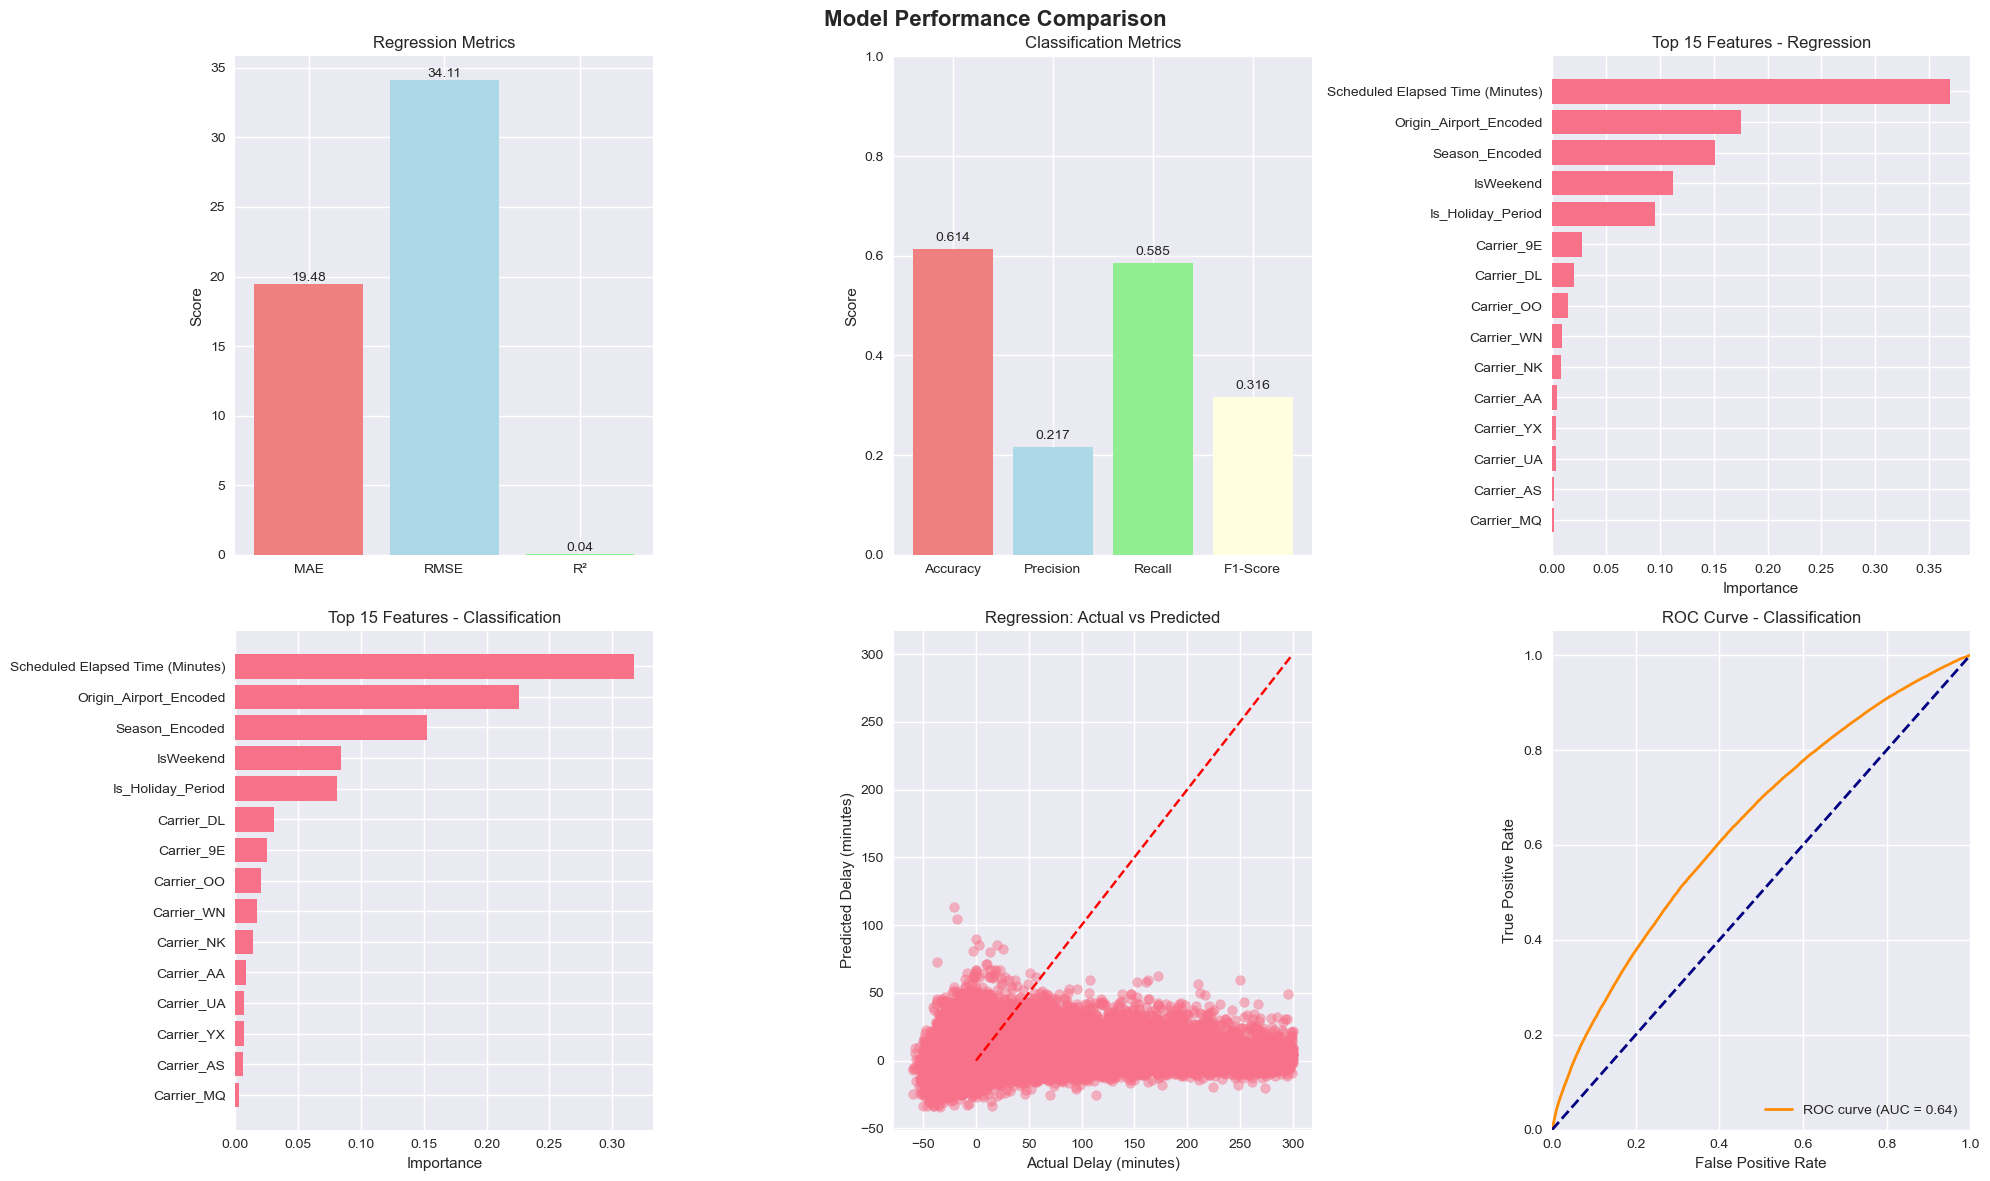

In [19]:
# Model Performance Visualization

def plot_model_performance(reg_metrics, clf_metrics, reg_feature_importance, clf_feature_importance):
    """Create comprehensive model performance visualizations."""
    print("\n📊 Creating model performance visualizations...")
    
    # 1. Regression vs Classification Metrics Comparison
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    # Regression Metrics
    if reg_metrics:
        reg_scores = [reg_metrics['MAE'], reg_metrics['RMSE'], reg_metrics['R2']]
        reg_labels = ['MAE', 'RMSE', 'R²']
        bars1 = axes[0, 0].bar(reg_labels, reg_scores, color=['lightcoral', 'lightblue', 'lightgreen'])
        axes[0, 0].set_title('Regression Metrics')
        axes[0, 0].set_ylabel('Score')
        # Add value labels on bars
        for bar, score in zip(bars1, reg_scores):
            axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                          f'{score:.2f}', ha='center', va='bottom')
    
    # Classification Metrics
    if clf_metrics:
        clf_scores = [clf_metrics['Accuracy'], clf_metrics['Precision'], 
                     clf_metrics['Recall'], clf_metrics['F1_Score']]
        clf_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        bars2 = axes[0, 1].bar(clf_labels, clf_scores, color=['lightcoral', 'lightblue', 'lightgreen', 'lightyellow'])
        axes[0, 1].set_title('Classification Metrics')
        axes[0, 1].set_ylabel('Score')
        axes[0, 1].set_ylim(0, 1)
        # Add value labels on bars
        for bar, score in zip(bars2, clf_scores):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                          f'{score:.3f}', ha='center', va='bottom')
    
    # Feature Importance - Regression
    if reg_feature_importance is not None:
        reg_feature_importance['importance'] = reg_feature_importance['importance'] / reg_feature_importance['importance'].sum()    
        top_reg_features = reg_feature_importance.head(15).iloc[::-1]
        axes[0, 2].barh(range(len(top_reg_features)), top_reg_features['importance'])
        axes[0, 2].set_yticks(range(len(top_reg_features)))
        axes[0, 2].set_yticklabels(top_reg_features['feature'])
        axes[0, 2].set_title('Top 15 Features - Regression')
        axes[0, 2].set_xlabel('Importance')
    
    # Feature Importance - Classification
    if clf_feature_importance is not None:
        clf_feature_importance['importance'] = clf_feature_importance['importance'] / clf_feature_importance['importance'].sum()
        top_clf_features = clf_feature_importance.head(15).iloc[::-1]
        axes[1, 0].barh(range(len(top_clf_features)), top_clf_features['importance'])
        axes[1, 0].set_yticks(range(len(top_clf_features)))
        axes[1, 0].set_yticklabels(top_clf_features['feature'])
        axes[1, 0].set_title('Top 15 Features - Classification')
        axes[1, 0].set_xlabel('Importance')
    
    # Prediction vs Actual (Regression)
    if 'y_test_reg' in globals() and 'y_pred_reg' in globals():
        axes[1, 1].scatter(y_test_reg, y_pred_reg, alpha=0.5)
        max_val = max(y_test_reg.max(), y_pred_reg.max())
        axes[1, 1].plot([0, max_val], [0, max_val], 'r--')
        axes[1, 1].set_xlabel('Actual Delay (minutes)')
        axes[1, 1].set_ylabel('Predicted Delay (minutes)')
        axes[1, 1].set_title('Regression: Actual vs Predicted')
    
    # ROC Curve (Classification)
    if 'clf_model' in globals() and 'X_test_clf' in globals() and 'y_test_clf' in globals():
        try:
            from sklearn.metrics import roc_curve, auc
            y_pred_proba = clf_model.predict_proba(X_test_clf)[:, 1]
            fpr, tpr, _ = roc_curve(y_test_clf, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            
            axes[1, 2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            axes[1, 2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            axes[1, 2].set_xlim([0.0, 1.0])
            axes[1, 2].set_ylim([0.0, 1.05])
            axes[1, 2].set_xlabel('False Positive Rate')
            axes[1, 2].set_ylabel('True Positive Rate')
            axes[1, 2].set_title('ROC Curve - Classification')
            axes[1, 2].legend(loc="lower right")
        except Exception as e:
            print(f"Could not plot ROC curve: {e}")
    
    plt.tight_layout()
    
    if CONFIG['save_figures']:
        plt.savefig('../results/figures/XGBoost_performance.png', dpi=300, bbox_inches='tight')
        print("✅ Saved model performance plot")
    
    plt.show()

# Plot performance
plot_model_performance(metrics_reg, metrics_clf, feature_importance_reg, feature_importance_clf)

In [13]:
# Save Models and Results

def save_models_and_results(reg_model, clf_model):
    """Save trained models and generate final report."""
    print("\n💾 Saving models and results...")
    
    # # Save regression model
    # reg_model.save_model(
    #     '../results/models/XGBoost_regressor.pkl',
    #     '../results/models/XGBoost_regression_features.pkl'
    # )
    
    # # Save classification model
    # clf_model.save_model(
    #     '../results/models/XGBoost_classifier.pkl',
    #     '../results/models/XGBoost_classification_features.pkl'
    # )
    
    # Generate performance report
    report = {
        'regression_metrics': metrics_reg,
        'classification_metrics': metrics_clf,
        'config': CONFIG,
        'timestamp': pd.Timestamp.now().isoformat()
    }
    
    import json
    with open('../results/models/XGBoost_performance_report.json', 'w') as f:
        json.dump(report, f, indent=2)
    
    print("✅ Models and results saved successfully!")
    print("📁 Check the 'results/' directory for all outputs")

# Save everything
save_models_and_results(reg_model, clf_model)


💾 Saving models and results...
✅ Models and results saved successfully!
📁 Check the 'results/' directory for all outputs


In [14]:
# Final Summary and Insights

def generate_final_summary():
    """Generate final training summary and insights."""
    print("\n" + "="*70)
    print("🎉 TRAINING COMPLETE - SUMMARY")
    print("="*70)
    
    print("\n📊 MODEL PERFORMANCE SUMMARY:")
    print("-" * 40)
    
    if metrics_reg:
        print(f"\n🔧 REGRESSION MODEL:")
        print(f"   • MAE: {metrics_reg['MAE']:.2f} minutes")
        print(f"   • RMSE: {metrics_reg['RMSE']:.2f} minutes")
        print(f"   • R²: {metrics_reg['R2']:.4f}")
        print(f"   • Predictions within 15min: {metrics_reg.get('Within_15min_%', 'N/A'):.1f}%")
    
    if metrics_clf:
        print(f"\n🎯 CLASSIFICATION MODEL:")
        print(f"   • Accuracy: {metrics_clf['Accuracy']:.4f}")
        print(f"   • Precision: {metrics_clf['Precision']:.4f}")
        print(f"   • Recall: {metrics_clf['Recall']:.4f}")
        print(f"   • F1-Score: {metrics_clf['F1_Score']:.4f}")
        if metrics_clf.get('ROC_AUC'):
            print(f"   • ROC-AUC: {metrics_clf['ROC_AUC']:.4f}")
    
    print(f"\n📁 OUTPUTS GENERATED:")
    print("-" * 40)
    # print("   • ../results/figures/data_distributions.png")
    print("   • ../results/figures/XGBoost_performance.png")
    # print("   • ../results/models/XGBoost_regressor.pkl")
    # print("   • ../results/models/XGBoost_classifier.pkl")
    print("   • ../results/models/XGBoost_performance_report.json")
    
    print(f"\n💡 RECOMMENDATIONS:")
    print("-" * 40)
    if metrics_reg and metrics_reg['R2'] > 0.7:
        print("   ✅ Regression model has good predictive power")
    else:
        print("   ⚠️  Consider feature engineering for regression")
        
    if metrics_clf and metrics_clf['F1_Score'] > 0.8:
        print("   ✅ Classification model performs well")
    else:
        print("   ⚠️  Try different balancing methods for classification")

# Generate final summary
generate_final_summary()


🎉 TRAINING COMPLETE - SUMMARY

📊 MODEL PERFORMANCE SUMMARY:
----------------------------------------

🔧 REGRESSION MODEL:
   • MAE: 19.48 minutes
   • RMSE: 34.11 minutes
   • R²: 0.0392
   • Predictions within 15min: 57.1%

🎯 CLASSIFICATION MODEL:
   • Accuracy: 0.6142
   • Precision: 0.2167
   • Recall: 0.5851
   • F1-Score: 0.3162
   • ROC-AUC: 0.6430

📁 OUTPUTS GENERATED:
----------------------------------------
   • ../results/figures/XGBoost_performance.png
   • ../results/models/XGBoost_performance_report.json

💡 RECOMMENDATIONS:
----------------------------------------
   ⚠️  Consider feature engineering for regression
   ⚠️  Try different balancing methods for classification
